In [20]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [2]:
'''
Loading chargers from JSON
'''
deep_reload(src)

vertices=src.store.Load('vertices.json')

In [3]:
'''
Making a graph from the vertices
'''
deep_reload(src)

graph=src.network.NX_Graph_From_Vertices(
    vertices,
)

In [72]:
'''
Loading parameters
'''
with open('parameters.json','rb') as file:
    parameters=json.load(file)

In [8]:
'''
Producing adjacency matrices
'''
deep_reload(src)

vehicle_adjacency,vehicle_nodes=src.router.ProcessInputs(graph,parameters)

In [13]:
'''
Computing routes for each vehicle and depot
'''
deep_reload(src)

vehicles=list(parameters['vehicles'].keys())
depots=parameters['depot_vertices']

raw_routes={}

t0=time.time()

for vehicle in vehicles:

    raw_routes[vehicle]={}

    for depot in depots:

        t1=time.time()
        print(f'Routing for {vehicle} from {depot} ... ',end='')

        adjacency=vehicle_adjacency[vehicle][depot]

        raw_routes[vehicle][depot]=src.router.ProduceRoutesVehicleDepot(
            graph,vehicle,depot,parameters,adjacency)

        print(f'Done, {time.time()-t1:.4f} seconds elapsed')

print(f'Routing complete, {time.time()-t0:.4f} seconds elapsed')

Routing for Bolt from 1000000000 ... Done, 5.8213 seconds elapsed
Routing for Bolt from 2000000000 ... Done, 7.6503 seconds elapsed
Routing for Model 3 from 1000000000 ... Done, 0.3322 seconds elapsed
Routing for Model 3 from 2000000000 ... Done, 0.1363 seconds elapsed
Routing for Lightning from 1000000000 ... Done, 7.2549 seconds elapsed
Routing for Lightning from 2000000000 ... Done, 5.1806 seconds elapsed
Routing for IONIQ 5 from 1000000000 ... Done, 5.3216 seconds elapsed
Routing for IONIQ 5 from 2000000000 ... Done, 6.0728 seconds elapsed
Routing complete, 37.7704 seconds elapsed


In [18]:
'''
Writing raw routes to .json
'''
deep_reload(src)

src.store.Write(raw_routes,'raw_routes.json')

In [52]:
'''
Writing raw routes to .json
'''
deep_reload(src)

raw_routes=src.store.Load('raw_routes.json')

In [21]:
'''
Loading in the charger rawdata
'''
deep_reload(src)

files=[
    'UCDavis_L2_Weighted_Sample.csv',
    'UCDavis_DCFC_Weighted_Sample.csv',
    'Depots.csv',
]

df=src.store.Read(files)

In [73]:
'''
Post-processing routes
'''
deep_reload(src)

vehicles=list(parameters['vehicles'].keys())
depots=parameters['depot_vertices']
fields=parameters['route_fields']

fields=([
    'ID','Station Name','City','State','ZIP',
    'Longitude','Latitude','DCFC','EV Network Clean'])

full_routes={}

for vehicle in vehicles:

    full_routes[vehicle]={}

    for depot in depots:

        full_routes[vehicle][depot]=src.post_processing.AddRouteInformation(
            raw_routes[vehicle][depot],df,fields)

In [74]:
'''
Writing raw routes to .json
'''
deep_reload(src)

src.store.Write(full_routes,'full_routes.json')

In [8]:
'''
Producing adjacency matrices
'''
deep_reload(src)

vehicle_adjacency,vehicle_nodes=src.router.ProcessInputs(graph,parameters)

In [6]:
'''
Computing routes for one vehicle/depot as an example
'''
deep_reload(src)

vehicle='Bolt'
depot=parameters['depot_vertices'][0]
adjacency=vehicle_adjacency[vehicle][depot]

final_routes=src.router.ProduceRoutesVehicleDepot(
    graph,vehicle,depot,parameters,adjacency)

In [9]:
deep_reload(src)

sg=src.network.Subgraph(graph,vehicle_nodes[vehicle][depot])

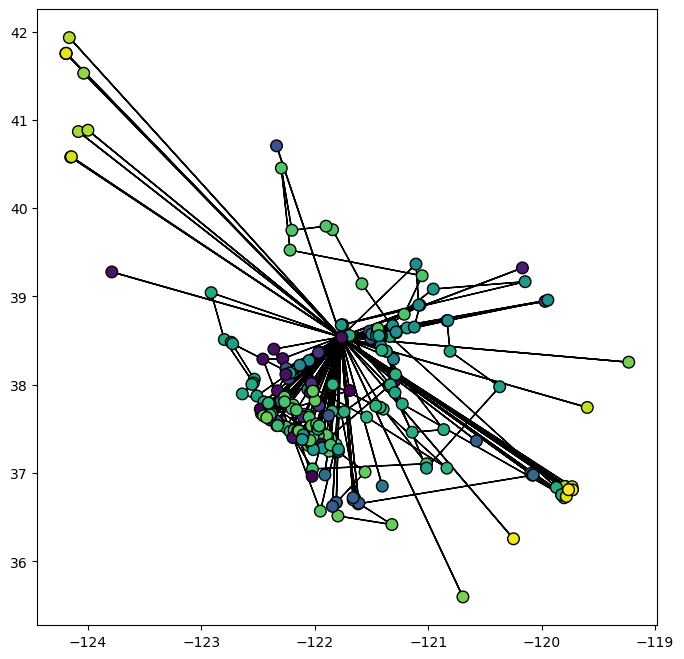

In [10]:
deep_reload(src)

fig,ax=plt.subplots(figsize=(8,8))

scatter_kwargs={
    'ec':'k',
    's':70,
}

arrow_kwargs={'zorder':0}

for n in sg.nodes:
    sg._node[n]['route_num']=0
    for idx,route in enumerate(final_routes):
        if n in route:
            sg._node[n]['route_num']=idx+1

cmap=src.figures.ReturnColorMap('viridis')

src.figures.PlotGraph(sg,ax=ax,cmap=cmap,field='route_num',
                      scatter_kwargs=scatter_kwargs)

cypher=adjacency['node_to_idx']
routes_idx_opt=[[cypher[stop] for stop in route] for route in final_routes]

src.figures.PlotRoute(sg,routes_idx_opt,ax=ax,cmap=cmap,
                      arrow_kwargs=arrow_kwargs,
                      scatter_kwargs=scatter_kwargs)